# Estimate Default Correlation of Lending Club Data

I apply Merton's single index model to Lending Club loan data to calculate Default Correlation within each cohort.  I found that default correlation is high for lower grade Lending Club customers, high for customers who own their own houses, high for customers with higher annual income, and high for larger-size loans.  The early loans have higher default correlations, and the Lending Club has lowered the default correlation over time, perhaps by diversifying the customers.

## Data Processing

I use lending club data from 2011 to 2016 for this analysis.

In [1]:
def process_data(data, var):
    data = data.loc[data['issue_d'].notnull(), var]
    data = data.loc[[x in ['Charged Off', 'Fully Paid'] for x in data['loan_status']],  :]
    issue_d = pd.to_datetime(data['issue_d'], errors='ignore', unit='ns')
    curr_d = max(issue_d)
    data['mob']=12 * (curr_d.year - issue_d.dt.year) + (curr_d.month - issue_d.dt.month) + 3
    # assume the current date is the max issue date + 3 month
    return data

In [2]:
var = ['loan_amnt', 'term', 'grade', 'sub_grade', 'issue_d', 
 'loan_status', 'addr_state', 'annual_inc', 'home_ownership']

In [3]:
import pandas as pd
d = pd.read_csv('~/datasets/lending_club/LoanStats3a.csv', skiprows = 1)
part1 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
d = pd.read_csv('~/datasets/lending_club/LoanStats3b.csv', skiprows = 1)
part2 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
d = pd.read_csv('~/datasets/lending_club/LoanStats3c.csv', skiprows = 1)
part3 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
d = pd.read_csv('~/datasets/lending_club/LoanStats3d.csv', skiprows = 1)
part4 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
d = pd.read_csv('~/datasets/lending_club/LoanStats_2016Q1.csv', skiprows = 1)
part5 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
d = pd.read_csv('~/datasets/lending_club/LoanStats_2016Q2.csv', skiprows = 1)
part6 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
d = pd.read_csv('~/datasets/lending_club/LoanStats_2016Q3.csv', skiprows = 1)
part7 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
d = pd.read_csv('~/datasets/lending_club/LoanStats_2016Q4.csv', skiprows = 1)
part8 = process_data(d, var)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
data = pd.concat([part1, part2, part3, part4, part5, part6, part7, part8], axis = 0)

In [12]:
data.shape

(1012240, 10)

## Estimate Default Correlation by Method of Moments

In [13]:
from scipy.stats import norm, uniform, multivariate_normal
from scipy.optimize import minimize
import numpy as np
# GMM value function for Merton Single Factor Corpula Model
def val_func(r, pd):
    p = np.mean(pd)
    d = norm.ppf(p)
    v = np.var(pd)
    e = v + p ** 2
    pnorm = multivariate_normal.cdf(x = [d, d], mean = [0, 0], cov = [[1, r], [r, 1]])
    return (e - pnorm) ** 2

In [14]:
data.columns

Index(['loan_amnt', 'term', 'grade', 'sub_grade', 'issue_d', 'loan_status',
       'addr_state', 'annual_inc', 'home_ownership', 'mob'],
      dtype='object')

## Grade

Lower-grade loans have higher default correlations.

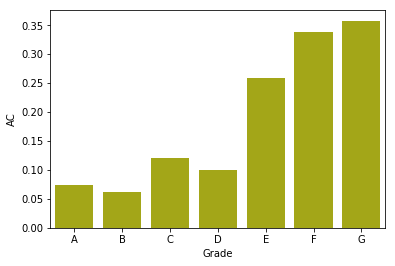

In [31]:
d0 = data[['mob', 'grade', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='grade', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in df.index:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(df.index, name = 'Grade'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'Grade', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## Term

No significant difference in default correlation lies between different terms of loans.

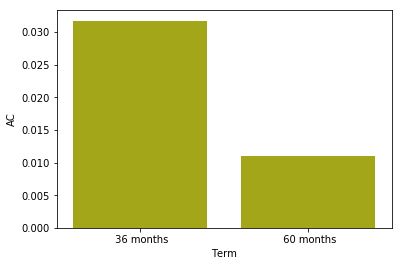

In [16]:
d0 = data[['mob', 'term', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='term', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in df.index:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(df.index, name = 'Term'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'Term', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## States

Default correlations iin the states of large clientele vary.  NY and TX have the lowest.

In [17]:
tab = data.groupby('addr_state').size()
st = tab[tab > 30000].index # focus on states with at least 30000 borrowers

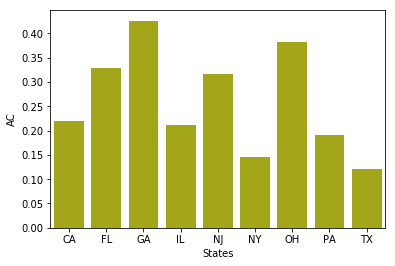

In [18]:
d0 = data[['mob', 'addr_state', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='addr_state', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in st:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(st, name = 'States'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'States', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## Home Ownership

Loans made to clients who own their own house have higher default correlations.

In [19]:
data.groupby(['home_ownership']).size()

home_ownership
ANY             52
MORTGAGE    500822
NONE            45
OTHER          144
OWN         104267
RENT        406910
dtype: int64

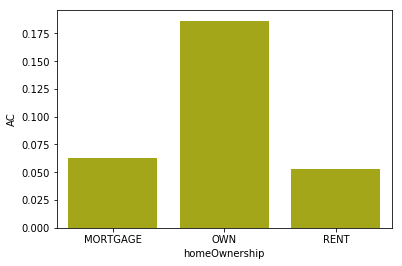

In [20]:
d0 = data[['mob', 'home_ownership', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='home_ownership', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in ['MORTGAGE', 'OWN', 'RENT']:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(['MORTGAGE', 'OWN', 'RENT'], name = 'homeOwnership'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'homeOwnership', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## Annual Income Groups

Default correlations of loans issued to clients of income above 120K are high.

In [21]:
data['annual_inc'].describe()/1000

count    1012.240000
mean       75.325737
std        66.099719
min         0.000000
25%        45.000000
50%        65.000000
75%        90.000000
max      9550.000000
Name: annual_inc, dtype: float64

In [22]:
out = []
for x in data['annual_inc']:
    if x <= 40000:
        out.append('low')
    elif x <= 120000:
        out.append('medium')
    else:
        out.append('high')
data['inc_group'] = out

In [23]:
data.groupby(['inc_group']).size()

inc_group
high      106747
low       186621
medium    718872
dtype: int64

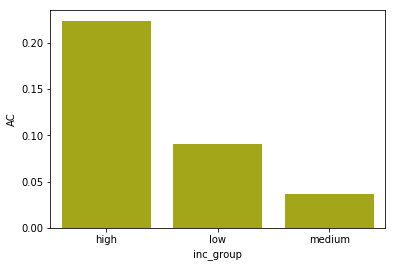

In [24]:
d0 = data[['mob', 'inc_group', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='inc_group', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in df.index:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(df.index, name = 'inc_group'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'inc_group', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## Loan Amount

Smaller loans have the lowest default correlation.

In [25]:
data['loan_amnt'].describe()

count    1.012240e+06
mean     1.439164e+04
std      8.497052e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

In [26]:
out = []
for x in data['loan_amnt']:
    if x <= 10000:
        out.append('small_loan')
    elif x <= 20000:
        out.append('medium_loan')
    else:
        out.append('large_loan')
data['loan_group'] = out

In [27]:
data.groupby(['loan_group']).size()

loan_group
large_loan     217255
medium_loan    384099
small_loan     410886
dtype: int64

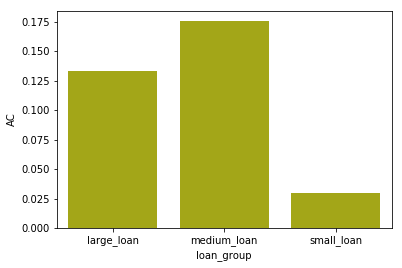

In [28]:
d0 = data[['mob', 'loan_group', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='loan_group', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in df.index:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(df.index, name = 'loan_group'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'loan_group', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()

## Loan Issue Years

Default correlations of earlier loans are the highest.  As the Lending Club grows its client base, the diversity of the clientele lowers the default correlation overtime. 

In [29]:
data['issue_y']  = [x.split("-")[1] for x in data['issue_d']]
data.groupby(['issue_y']).size()

issue_y
2007       251
2008      1562
2009      4716
2010     11536
2011     21721
2012     53367
2013    133111
2014    217415
2015    341460
2016    227101
dtype: int64

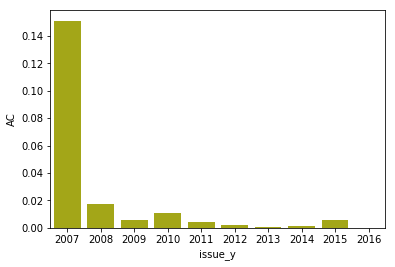

In [30]:
d0 = data[['mob', 'issue_y', 'loan_status']].reset_index()
df = pd.pivot_table(d0, index='issue_y', 
                 columns=['loan_status', 'mob'],
                 fill_value=0,
                 aggfunc='count')
res = []
for g in df.index:
    d = df.loc[g].unstack().fillna(0)
    probD = d.iloc[0, :]/(d.iloc[0, :] + d.iloc[1, :])
    out = minimize(val_func, method = 'Nelder-Mead', x0 = 0.5, args = probD)
    res.append(float(out.x))

pltDf = pd.concat([pd.Series(df.index, name = 'issue_y'), pd.Series(res, name = 'AC')], axis = 1)
from matplotlib import pyplot as plt
import seaborn as sns
sns.barplot(x = 'issue_y', y = 'AC', data = pltDf, color = '#b9be00')
plt.show()